In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [ ]:
# 2. Load Data
print(" Loading Online Shoppers Data")
df = pd.read_csv('online_shoppers_intention.csv')
print(f"Data Shape: {df.shape}")
display(df.head())

In [ ]:
# 3. Data Preprocessing
print("Starting Preprocessing...")

# Handle Missing Values and Duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f"Data Shape after cleaning: {df.shape}")

# Feature Selection
features = ['PageValues', 'ExitRates', 'ProductRelated_Duration', 'BounceRates']
X = df[features].copy()

# Log Transformation for skewed columns
for col in ['PageValues', 'ProductRelated_Duration']:
    X[col] = np.log1p(X[col])

# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Preprocessing complete. Data ready for clustering. Shape: {X_pca.shape}")

In [32]:
#dbscan
print("Running DBSCAN")

dbscan = DBSCAN(eps=0.8, min_samples=50)
labels_db = dbscan.fit_predict(X_pca)

score_db = silhouette_score(X_pca, labels_db)
print(f"Silhouette Score (DBSCAN): {score_db:.4f}")

print("Cluster counts:")
print(pd.Series(labels_db).value_counts())


Silhouette Score (DBSCAN): 0.7623
Cluster counts:
1    11622
0      583
Name: count, dtype: int64


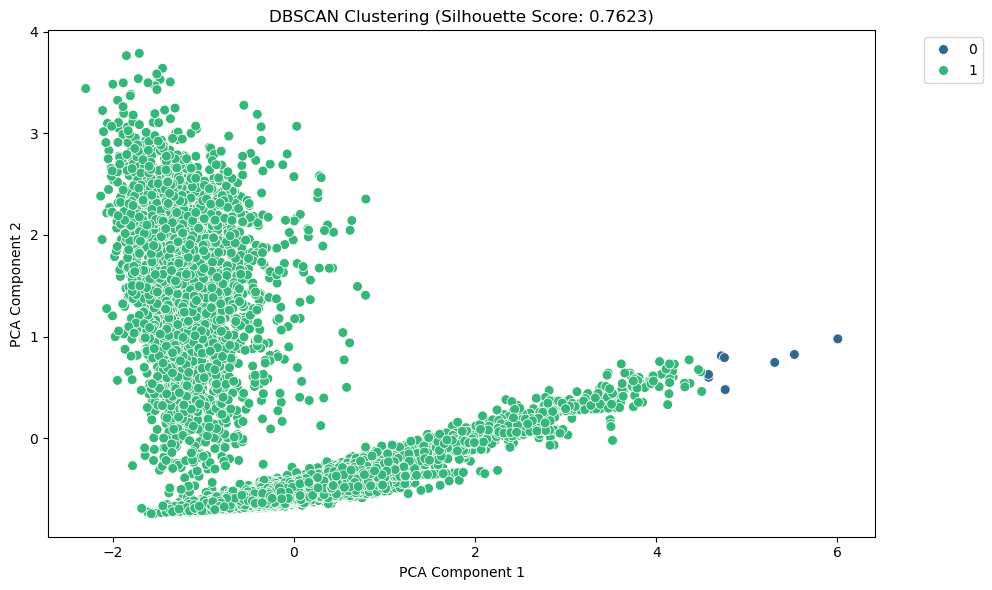

In [34]:
# Visualize DBSCAN Clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_db, palette='viridis', s=50)
plt.title(f'DBSCAN Clustering (Silhouette Score: {score_db:.4f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Loading and preprocessing data...

Final segment mapping:
-1 : Bouncers (Outliers)
 0 : Browsers (Low value)
 1 : Buyers (High value)

Cluster statistics:
               PageValues  BounceRates  ProductRelated_Duration
Final_Segment                                                  
-1              54.383022     0.066667               432.069418
 0               0.000000     0.199924                 0.000000
 1               6.170168     0.011376              1268.169134

Silhouette Score (DBSCAN): 0.5420


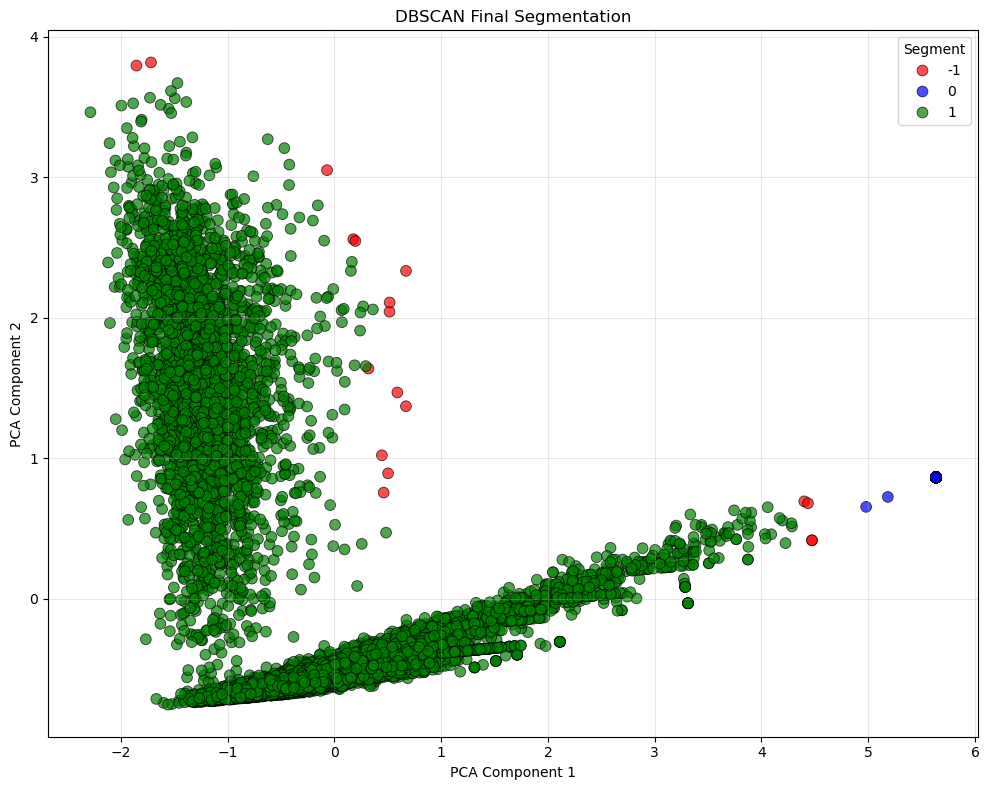

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 1. Data loading and preprocessing
print("Loading and preprocessing data...")

df = pd.read_csv('online_shoppers_intention.csv')

features = ['PageValues', 'ExitRates', 'ProductRelated_Duration', 'BounceRates']
X = df[features].copy()

# Log transform to reduce skewness
for col in ['PageValues', 'ProductRelated_Duration']:
    X[col] = np.log1p(X[col])

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. DBSCAN clustering
# eps is chosen to allow noise points (-1)
dbscan = DBSCAN(eps=0.5, min_samples=50)
raw_labels = dbscan.fit_predict(X_pca)

# 3. Relabel clusters based on business meaning
#  0 : Browsers 1 : Buyers -1 : Noise / Bouncers  
df['Temp_Label'] = raw_labels
final_labels = raw_labels.copy()

# Identify real clusters (exclude noise)
clusters = [c for c in np.unique(raw_labels) if c != -1]

# Compute average PageValues per cluster
cluster_avg_pv = {
    c: df[df['Temp_Label'] == c]['PageValues'].mean()
    for c in clusters
}

# Sort clusters by PageValues
sorted_clusters = sorted(cluster_avg_pv, key=cluster_avg_pv.get)

browser_cluster = sorted_clusters[0]
buyer_cluster = sorted_clusters[1]

# Apply final labels
final_labels[raw_labels == browser_cluster] = 0
final_labels[raw_labels == buyer_cluster] = 1

# Save final segmentation
df['Final_Segment'] = final_labels

# 4. Validation and statistics
print("\nFinal segment mapping:")
print("-1 : Bouncers (Outliers)")
print(" 0 : Browsers (Low value)")
print(" 1 : Buyers (High value)")

print("\nCluster statistics:")
stats = df.groupby('Final_Segment')[
    ['PageValues', 'BounceRates', 'ProductRelated_Duration']
].mean()
print(stats)

# Silhouette score (only if valid)
if len(set(raw_labels) - {-1}) > 1:
    score = silhouette_score(X_pca, raw_labels)
    print(f"\nSilhouette Score (DBSCAN): {score:.4f}")
else:
    print("\nSilhouette Score: Not defined")

# 5. Visualization
plt.figure(figsize=(10, 8))

palette = {-1: 'red', 0: 'blue', 1: 'green'}

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=final_labels,
    palette=palette,
    s=60,
    alpha=0.7,
    edgecolor='k'
)

plt.title('DBSCAN Final Segmentation')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Segment')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()